## Rectangular waveguide - Discussion

In [1]:
import os
import sys
import fenics as fen
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg

In [2]:
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('__file__')))))
from rectangular_waveguide import RectangularWaveguide
import src.helpers as helpers
from src.vector_space import VectorSpaceL2

### Dimensions and properties

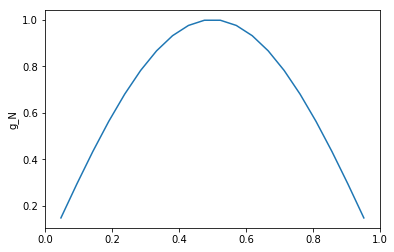

In [3]:
Lx, Ly = 5.0, 1.0
Nx, Ny = 101, 21
m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)
WG = RectangularWaveguide(Lx=Lx, Ly=Ly, Nx=Nx, Ny=Ny, g_N=g_N)
WG.setup()
WG.plot_g_N()

### Solution of problem

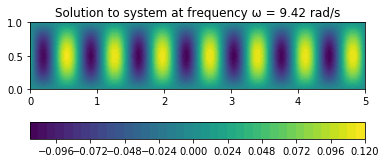

In [4]:
WG.solve(9.42)
WG.plot_solution()

In [5]:
class trace(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], 0.0) and x[1]>0.0 and x[1]<WG.Ly

VS = VectorSpaceL2(WG)

KeyboardInterrupt: 

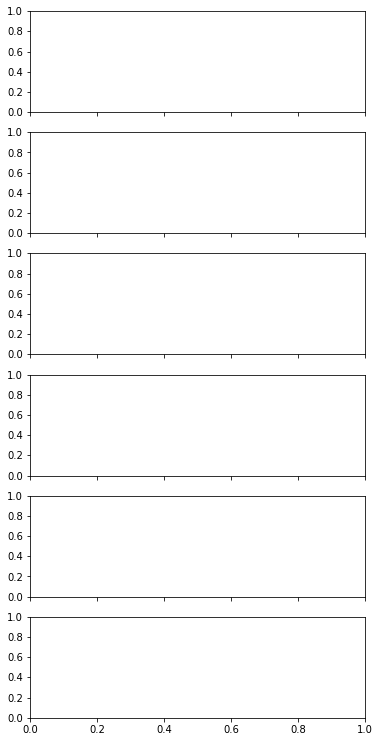

In [6]:
fig, ax = plt.subplots(6, 1, figsize=(6, 13), sharex=True)
omegas = np.linspace(3, 7, 300)
helpers.plot_L2_norms(ax[0], WG, omegas, VS)
helpers.plot_surrogate_L2_norms(ax[1], WG, 15, omegas, VS)
helpers.plot_eigvecs_dot_N(ax[2], WG, omegas[2], omegas[-1], width=0.05)
helpers.plot_numerical_eigenfrequencies(ax[3], WG, omegas[0], omegas[-1])
helpers.plot_analytical_eigenfrequencies(ax[4], WG, omegas[0], omegas[-1])
helpers.plot_interpolatory_eigenfrequencies(ax[5], WG, omegas[0], omegas[-1], 15, VS)
ax[0].set_ylabel('L\u2082-norm solution')
ax[1].set_ylabel('L\u2082-norm interpolant')
ax[2].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[3].set_ylabel('Analytical eigenmodes')
ax[3].set_yticks([])
ax[4].set_ylabel('Numerical eigenmodes')
ax[4].set_yticks([])
ax[5].set_ylabel('Interpolatory eigenmodes')
ax[5].set_yticks([])
ax[5].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[5].set_xlim(omegas[0], omegas[-1])
plt.show()

In [76]:
def get_numerator_argmin(RF, choices):
    tiled_choices = np.tile(choices, (len(RF.nodes), 1)).T
    index_min = np.argmin(np.abs(RF.q @ (tiled_choices - RF.nodes).T**(-1)))
    return index_min

def compute_greedy_surrogate(WG, VS, a, b, tol=1e-2):
    """Compute the rational surrogate with given support points"""
    omegas = [a, b]
    WG.solve(omegas)
    WG.compute_surrogate(VS, omegas)
    RF = WG.RI
    choices = np.linspace(a, b, 1000)[1:-1]
    while len(choices) > 0:
        index_min = get_numerator_argmin(RF, choices):
        omega_min = choices[index_min]
        WG.solve(omega_min, accumulate=True)
        A = WG.get_solution(tonumpy=True)[-1]
        if VS.norm(A - RF(omega_min)) <= tol*VS.norm(A):
            break
        choices = np.delete(choices, index_min)
        omegas.append(omega_min)
        WG.compute_surrogate(VS, omegas)
        RF = WG.RI

In [77]:
compute_greedy_surrogate(WG, VS, 3, 7)
WG.RI.nodes

array([ 3.        ,  7.        ,  3.1961962 ,  3.34434434,  3.75675676,
        3.8968969 ,  5.14614615,  3.52452452,  4.43743744,  4.93393393,
        6.57957958,  6.14714715,  5.87487487,  4.23323323,  6.79179179,
        5.67067067,  6.20720721,  6.75975976,  4.67367367])

In [85]:
omegas = np.linspace(3, 4, 100)
WG.solve(omegas)
A = WG.get_solution(tonumpy=True)
R3 = helpers.householder_triangularization(A, VS)
R3

array([[ 0.54786005,  0.43748879,  0.80704896],
       [ 0.        ,  2.25352258,  0.12271663],
       [ 0.        ,  0.        ,  4.34239377]])

In [86]:
R2 = helpers.householder_triangularization(WG.get_solution(tonumpy=True)[:2], VS)
R2

array([[ 0.54786005,  0.43748879],
       [ 0.        ,  2.25352258]])

In [96]:
def householder_triangularization(A_, VS):
    """Compute the matrix R of a QR-decomposition of A"""
    A = A_.copy()
    
    N = A.shape[0]
    E = helpers.get_orthonormal_matrix(A.shape, VS)
    R = np.zeros((N, N))

    vs = []
    
    for k in range(N):
        R[k, k] = VS.norm(A[k])
        alpha = VS.inner_product(E[k], A[k])
        if abs(alpha) > 1e-17:
            E[k] *= - alpha / abs(alpha)

        v = R[k, k] * E[k] - A[k]
        for j in range(k):
            v -= VS.inner_product(E[j], v) * E[j]

        sigma = VS.norm(v)
        if abs(sigma) > 1e-17:
            v /= sigma
        else:
            v = E[k]

        for j in range(k+1, N):
            A[j] -= 2 * v * VS.inner_product(v, A[j])
            R[k, j] = VS.inner_product(E[k], A[j])
            A[j] -= E[k] * R[k, j]

        vs.append(v)
    return R, E, vs

R, E, vs = householder_triangularization(WG.get_solution(tonumpy=True)[:2], VS)
R

array([[ 0.54786005,  0.43748879],
       [ 0.        ,  2.25352258]])

In [100]:
def additive_householder_triangularization(a_, R, E, vs, VS):
    """Compute the matrix R of a QR-decomposition of A"""
    a = a_.copy()

    N = R.shape[0]
    R = np.pad(R, (0, 1), mode='constant')

    for k in range(N):
        a -= 2 * vs[k] * VS.inner_product(vs[k], a)
        R[k, N] = VS.inner_product(E[k], a)
        a -= E[k] * R[k, N]

    R[N, N] = VS.norm(a)

    E_new = np.random.randn(len(a))
    for j in range(N):
        E_new -= VS.inner_product(E[j], E_new) * E[j]
    E_new /= VS.norm(E_new)
    E = np.c_[E.T, E_new].T

    alpha = VS.inner_product(E[N], a)
    if abs(alpha) > 1e-17:
        E[N] *= - alpha / abs(alpha)

    v = R[N, N] * E[N] - a
    for j in range(N):
        v -= VS.inner_product(E[j], v) * E[j]

    sigma = VS.norm(v)
    if abs(sigma) > 1e-17:
        v /= sigma
    else:
        v = E[k]

    vs.append(v)

    return R, E, vs

R, E, vs = additive_householder_triangularization(WG.get_solution(tonumpy=True)[4], R, E, vs, VS)

In [101]:
omegas = np.linspace(3, 4, 100)
WG.solve(omegas)
A = WG.get_solution(tonumpy=True)

In [102]:
%timeit householder_triangularization(A, VS)

1.27 s ± 38.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [104]:
R, E, vs = householder_triangularization(A[:-1], VS)

In [105]:
%timeit additive_householder_triangularization(A[-1], R, E, vs, VS)

24.5 ms ± 535 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Timing

In [ ]:
omega = WG.get_analytical_eigenfrequencies(0, 10)[0]

#### FEniCS solver

In [ ]:
LHS = WG.get_K(tosparse=False) - omega**2 * WG.get_M(tosparse=False)
RHS = WG.get_L(tonumpy=False) + WG.get_N(tonumpy=False)
A_sol = fen.Function(WG.get_V())
%timeit fen.solve(LHS, A_sol.vector(), RHS)

#### SciPy sparse Hermitian eigenvalue solver

In [ ]:
valid_indices = WG.get_valid_indices()
K = WG.get_K()[valid_indices, :][:, valid_indices]
M = WG.get_M()[valid_indices, :][:, valid_indices]
%timeit scipy.sparse.linalg.eigsh(K, k=1, M=M, sigma=omega**2)

### Compare methods

In [ ]:
Lx, Ly = 5.0, 1.0
m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)

for N in np.logspace(2, 5, 4, dtype=int):
    WG = RectangularWaveguide(Lx=Lx, Ly=Ly, Nx=int(pow(N*Lx/(Lx+Ly), 0.5)), Ny=int(pow(N*Ly/(Lx+Ly), 0.5)), g_N=g_N)
    WG.setup()
    VS = VectorSpaceL2(WG)
    fig, ax = plt.subplots(2, 1, figsize=(9, 4), sharex=True)
    omega_min, omega_max = 3, 5
    helpers.plot_analytical_eigenfrequencies(ax[0], WG, omega_min, omega_max, alpha=0.5, color='C0')
    t_FE = helpers.plot_numerical_eigenfrequencies(ax[0], WG, omega_min, omega_max, k=6, timer=True)
    helpers.plot_analytical_eigenfrequencies(ax[1], WG, omega_min, omega_max, alpha=0.5, color='C0')
    t_RI = helpers.plot_interpolatory_eigenfrequencies(ax[1], WG, omega_min, omega_max, S=10, VS=VS, timer=True)
    ax[0].set_title(f'Rectangular waveguide with {N} elements')
    ax[0].set_ylabel('Scipy eigsh')
    ax[0].text(0.85, 1.03, f't = {round(t_FE, 5)} s', transform=ax[0].transAxes)
    ax[0].set_yticks([])
    ax[1].set_ylabel('Rational interpolation')
    ax[0].text(0.85, 1.03, f't = {round(t_RI, 5)} s', transform=ax[1].transAxes)
    ax[1].set_yticks([])
    ax[1].set_xlabel('Frequency \u03C9 (in rad/s)')
    plt.show()